In [1]:
from functions import *

In [2]:
column_names = ['chrom', 'chromStart', 'chromEnd', 'name', 'score',
              'strand', 'signalValue', 'pValue', 'qValue', 'peak']

chrom = 'chr6'
coord = [52012980, 52345139]

ctcf_chip_path = '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/genomeData/ctcfChIP/GSE96107_ES_CTCF.IDR0.05.filt.narrowPeak.gz' 
ring_chip_path = '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/genomeData/ring1ChIP/GSE96107_ES_CTCF.IDR0.05.filt.narrowPeak.gz'
rad21_chip_path = '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/genomeData/rad21ChIP/GSE137272_Rad21-ChIPseq.narrowPeak'

ring_df = pd.read_csv(ring_chip_path, delimiter='\t', header=None)
ctcf_df = pd.read_csv(ctcf_chip_path, delimiter='\t', header=None)
rad21_df = pd.read_csv(rad21_chip_path, delimiter='\t', header=None, skiprows=1)

ring_df.columns = column_names
ctcf_df.columns = column_names
rad21_df.columns = column_names

condition = lambda df: (df.chrom == chrom) & (df.chromStart >= coord[0]) & (df.chromEnd <= coord[1]) & (df.score == 1000)

ring_df = ring_df.loc[condition(ring_df)]
ctcf_df = ctcf_df.loc[(condition(ctcf_df)) & (ctcf_df.signalValue > ctcf_df.signalValue.median())]
rad21_df = rad21_df.loc[(rad21_df.chrom == chrom) & (rad21_df.chromStart >= coord[0]) & (rad21_df.chromEnd <= coord[1]) & (rad21_df.score > rad21_df.score.median())]

In [3]:
ctcf_df['bin'] = pd.cut(ctcf_df['chromStart'], bins=np.arange(coord[0], coord[1], 1000), labels=False)

In [4]:
ring_df['bin'] = pd.cut(ring_df['chromStart'], bins=np.arange(coord[0], coord[1], 1000), labels=False)

In [5]:
rad21_df['bin'] = pd.cut(rad21_df['chromStart'], bins=np.arange(coord[0], coord[1], 1000), labels=False)

In [6]:
rad21_ctcf_common = set(rad21_df.bin) & set(ctcf_df.bin)

In [7]:
ctcf_df = ctcf_df.loc[ctcf_df.bin.isin(rad21_ctcf_common)]
rad21_df = rad21_df.loc[rad21_df.bin.isin(rad21_ctcf_common)]

In [76]:
rad21_df

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,bin
94611,chr6,52027184,52027590,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,220,.,0,0,0,192,14
94615,chr6,52045512,52045971,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,451,.,0,0,0,225,32
94624,chr6,52107354,52108008,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,364,.,0,0,0,231,94
94626,chr6,52122700,52123237,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,108,.,0,0,0,126,109
94645,chr6,52197204,52197835,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,447,.,0,0,0,247,184
94650,chr6,52211232,52212177,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,395,.,0,0,0,489,198
94652,chr6,52221191,52222236,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,1270,.,0,0,0,609,208
94658,chr6,52240231,52240995,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,157,.,0,0,0,295,227
94664,chr6,52256711,52257507,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,916,.,0,0,0,436,243
94668,chr6,52270366,52271188,/mnt/home/tudomlumleart/ceph/01_TetheringSimul...,434,.,0,0,0,359,257


In [8]:
ctcf_df = ctcf_df.sort_values(by='chromStart')

In [9]:
# direction is calculated by 
# checking if rad21 peak is to the left of ctcf peak, if True, set it to 2
# else, set it to 1
ctcf_dir = (((rad21_df.chromStart + rad21_df.peak).values - (ctcf_df.chromStart + ctcf_df.peak).values) < 0) + 1

In [10]:
ctcf_df['dir'] = ctcf_dir

In [80]:
def logistic_function(x):
    # this make sure that the boundary between two tads are strong
    mean = x.signalValue[x.signalValue < 1000].median()
    slope = 0.01
    return 1/(1 + np.exp(-slope*(x.signalValue-mean)))

In [81]:
ctcf_df['BEprob'] = logistic_function(ctcf_df)

In [82]:
ctcf_df

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,bin,dir,BEprob
94909,chr6,52027145,52027553,.,1000,.,791.73362,-1.0,5.23457,204,14,1,0.794459
111688,chr6,52045541,52045975,.,1000,.,1446.55594,-1.0,5.23457,222,32,2,0.999629
103573,chr6,52107417,52107818,.,1000,.,1080.84941,-1.0,5.23457,189,94,2,0.985841
85187,chr6,52122615,52123018,.,1000,.,534.96491,-1.0,5.23457,199,109,1,0.228699
77513,chr6,52197302,52197642,.,1000,.,392.13123,-1.0,5.23457,163,184,2,0.066359
110246,chr6,52211515,52211936,.,1000,.,1369.79677,-1.0,5.23457,212,198,2,0.999202
120043,chr6,52221594,52222073,.,1000,.,2273.76314,-1.0,5.23457,224,208,2,1.000000
119876,chr6,52240304,52240791,.,1000,.,2233.09605,-1.0,5.23457,245,227,2,1.000000
102154,chr6,52256910,52257336,.,1000,.,1026.60798,-1.0,5.23457,207,243,1,0.975891
99679,chr6,52270488,52270921,.,1000,.,938.62278,-1.0,5.23457,207,257,1,0.943795


In [83]:
save_folder = '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_2_dirCTCF_sticky/'

In [15]:
ring_level_bin = np.linspace(ring_df.signalValue.min()-1, ring_df.signalValue.max(), 4)

In [16]:
ring_df['levelBin'] = pd.cut(ring_df['signalValue'], bins=ring_level_bin, labels=False)

In [159]:
ring_df

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,bin,levelBin
32868,chr6,52232446,52232846,.,1000,.,102.92110,-1.0,4.77538,200,219,0
38331,chr6,52255468,52255654,.,1000,.,117.71832,-1.0,5.23457,108,242,0
39989,chr6,52100217,52100343,.,1000,.,122.54602,-1.0,5.23457,70,87,0
48582,chr6,52229470,52229685,.,1000,.,153.31183,-1.0,5.23457,101,216,0
49435,chr6,52102817,52102927,.,1000,.,156.88858,-1.0,5.23457,51,89,0
50299,chr6,52291785,52291930,.,1000,.,160.44417,-1.0,5.23457,81,278,0
54425,chr6,52279322,52279545,.,1000,.,180.67807,-1.0,5.23457,122,266,0
59571,chr6,52344101,52344343,.,1000,.,209.30225,-1.0,5.23457,128,331,0
60860,chr6,52280717,52280967,.,1000,.,217.35887,-1.0,5.23457,99,267,0
63763,chr6,52186578,52186835,.,1000,.,239.16471,-1.0,5.23457,139,173,0


In [84]:
# Test generating polymers
num_monomers = len(np.arange(coord[0], coord[1], 1000))
num_polymers = 1
num_observations = 50 
ctcf_sites = ctcf_df.bin.values
ctcf_directions = ctcf_df.dir.values
ctcf_stall_probs = ctcf_df.BEprob.values 
monomer_types = np.zeros(num_monomers).astype(int)
monomer_types[ring_df.bin.values] = ring_df.levelBin.values 
interaction_matrix = np.array([[0, 0, 0], [0, 1.5, 1.5], [0, 1.5, 2]])

In [68]:
import time

def generate_polymer_chain(
    num_monomers: int, 
    num_polymers: int,
    num_observations: int, 
    save_folder: str, 
    # optional arguments 
    monomer_types: np.ndarray = None, # make sure that len(monomer_type_list) == num_monomers 
    interaction_matrix: np.ndarray = None, # make sure dim = monomer_types x monomer_types 
    ctcf_sites: list = [],
    ctcf_directions: list = None, # make sure len(dir) == len(sites)
    ctcf_stall_probs: list = None, 
    num_lef: int = None, 
    lef_load_prob: float = None , 
    extra_bond_pairs: list = [] # make sure it is nested 
    ): 
    """ 
    Add documentation here
    """
    if save_folder[-1] != '/':
        save_folder += '/'
    
    # Initialize optional arguments 
    if monomer_types is None:
        monomer_types = np.zeros(num_monomers).astype(int)
    assert len(monomer_types) == num_monomers, "The length of monomer_types types should equal to num_monomers!"
    
    num_unique_monomer_type = len(np.unique(monomer_types))
    if interaction_matrix is None:
        interaction_matrix = np.zeros([num_unique_monomer_type, num_unique_monomer_type]).astype(int)
    assert interaction_matrix.shape == (num_unique_monomer_type, num_unique_monomer_type), \
            "The dimension of interaction matrix should equal to the number of unique monomer types x the number of unique monomer types!"
    
    if ctcf_directions is None:
        if len(ctcf_sites) == 0:
            ctcf_directions = []
        else:
            ctcf_directions = np.zeros(len(ctcf_sites)).astype(int)
    assert len(ctcf_directions) == len(ctcf_sites), "The number of CTCF directions should equal to the number of CTCF sites!"
    
    
    if lef_load_prob is None:
        lef_load_prob = np.tile(np.ones([1, num_monomers]), [1, num_polymers])
        lef_load_prob = lef_load_prob / np.sum(lef_load_prob)
    
    # Simulation parameters 
    density = 0.002  # density of the PBC box 
    N1 = num_monomers  # Number of monomers in the polymer
    M = num_polymers  # Number of separate chains in the same volume 
    N = N1 * M # Number of monomers in the full simulation 
    LIFETIME = 200  # [Imakaev/Mirny use 200 as demo] extruder lifetime
    SEPARATION = 10  # Average separation between extruders in monomer units
    ctcfSites = ctcf_sites
    nCTCF = np.shape(ctcfSites)[0]
    ctcfDir = ctcf_directions  # 0 is bidirectional, 1 is right 2 is left
    if ctcf_stall_probs is None:
        ctcfCapture = 0.99 * np.ones(nCTCF)  # capture probability per block if capture < than this, capture
        ctcfRelease = 0.01 * np.ones(nCTCF)  # release probability per block. if capture < than this, release
    else:
        ctcf_stall_probs = np.array(ctcf_stall_probs)
        ctcfCapture = ctcf_stall_probs
        ctcfRelease = 1 - ctcf_stall_probs
    assert len(ctcfCapture) == nCTCF, 'the length of ctcfCapture should equal to nCTCF!'
    assert len(ctcfRelease) == nCTCF, 'the length of ctcfRelease should equal to nCTCF!'
    
    oneChainMonomerTypes = monomer_types
    interactionMatrix = interaction_matrix
    loadProb = lef_load_prob
    print(loadProb)
    
    if num_lef is None:
        if len(ctcf_sites) == 0:
            num_lef == 0
        else:
            num_lef = num_monomers // SEPARATION
            
    LEFNum = num_lef
    monomers = N1
    
    # less common parameters
    attraction_radius = 1.5  # try making this larger; I might have to change repulsion radius too 
    num_chains = M  # simulation uses some equivalent chains  (5 in a real sim)
    MDstepsPerCohesinStep = 800
    smcBondWiggleDist = 0.2
    smcBondDist = 0.5
    angle_force = 1.5  # most sims ran with 1.5.  0 might have been better
    
    # save pars
    saveEveryBlocks = 100  # save every 10 blocks
    numObservations = num_observations
    restartSimulationEveryBlocks = numObservations * saveEveryBlocks # blocks per iteration
    trajectoryLength = restartSimulationEveryBlocks  # 100000 # time duration of simulation (down from 100,000)
    
    # check that these loaded alright
    print(f'LEF count: {LEFNum}')
    print('interaction matrix:')
    print(interactionMatrix)
    print('monomer types:')
    print(oneChainMonomerTypes)
    print(save_folder)
    
    newFolder = save_folder
    lefPosFile = save_folder + "LEFPos.h5"
    # remove previous LEFPos.h5 file
    if os.path.isfile(lefPosFile):
        os.remove(lefPosFile)
        
    # generate a new folder  
    if not os.path.isdir(newFolder):
        os.makedirs(newFolder)
    else:
        shutil.rmtree(newFolder)
        os.makedirs(newFolder)
        
    reporter = HDF5Reporter(folder=newFolder, max_data_length=100, check_exists=False)
    print('creating folder')
    
    # ==================================#
    # Run and load 1D simulation
    # =================================#
    
    ctcfLeftRelease = {}
    ctcfRightRelease = {}
    ctcfLeftCapture = {}
    ctcfRightCapture = {}
    
    # should modify this to allow directionality
    for i in range(M):  # loop over chains (this variable needs a better name Max)
        for t in range(len(ctcfSites)):
            print(ctcfSites)
            pos = i * N1 + ctcfSites[t]
            
            if ctcfDir[t] == 0:
                ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
                ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
                ctcfRightCapture[pos] = ctcfCapture[t]
                ctcfRightRelease[pos] = ctcfRelease[t]
            elif ctcfDir[t] == 1:  # stop Cohesin moving toward the right
                ctcfLeftCapture[pos] = 0
                ctcfLeftRelease[pos] = 1
                ctcfRightCapture[pos] = ctcfCapture[t]
                ctcfRightRelease[pos] = ctcfRelease[t]
            elif ctcfDir[t] == 2:
                ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
                ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
                ctcfRightCapture[pos] = 0
                ctcfRightRelease[pos] = 1
        
    args = {}
    args["ctcfRelease"] = {-1: ctcfLeftRelease, 1: ctcfRightRelease}
    args["ctcfCapture"] = {-1: ctcfLeftCapture, 1: ctcfRightCapture}
    args["N"] = N
    args["LIFETIME"] = LIFETIME
    args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled
    
    occupied = np.zeros(N)
    occupied[0] = 1  # (I think this is just prevent the cohesin loading at the end by making it already occupied)
    occupied[-1] = 1  # [-1] is "python" for end
    cohesins = []
    
    print('starting simulation with N LEFs=')
    print(LEFNum)
    for i in range(LEFNum):
        ex1D.loadOneFromDist(cohesins, occupied, args, loadProb)  # load the cohesins
    
    with h5py.File(lefPosFile, mode='a') as myfile:
        dset = myfile.create_dataset("positions",
                                        shape=(trajectoryLength, LEFNum, 2),
                                        dtype=np.int32,
                                        compression="gzip")
        steps = 100  # saving in 50 chunks because the whole trajectory may be large
        bins = np.linspace(0, trajectoryLength, steps, dtype=int)  # chunks boundaries
        for st, end in zip(bins[:-1], bins[1:]):
            cur = []
            for i in range(st, end):
                ex1D.translocate(cohesins, occupied, args, loadProb)  # actual step of LEF dynamics
                positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
                cur.append(positions)  # appending current positions to an array
            cur = np.array(cur)  # when we finished a block of positions, save it to HDF5
            dset[st:end] = cur
        myfile.attrs["N"] = N
        myfile.attrs["LEFNum"] = LEFNum
    
    # =========== Load LEF simulation ===========#
    trajectory_file = h5py.File(lefPosFile, mode='r')
    LEFNum = trajectory_file.attrs["LEFNum"]  # number of LEFs
    LEFpositions = trajectory_file["positions"]  # array of LEF positions
    steps = MDstepsPerCohesinStep  # MD steps per step of cohesin  (set to ~800 in real sims)
    Nframes = LEFpositions.shape[0]  # length of the saved trajectory (>25000 in real sims)
    print(f'Length of the saved trajectory: {Nframes}')
    block = 0  # starting block
    
    # test some properties
    # assertions for easy managing code below
    assert (Nframes % restartSimulationEveryBlocks) == 0
    assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0
    
    savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
    simInitsTotal = (Nframes) // restartSimulationEveryBlocks
    # concatinate monomers if needed
    if len(oneChainMonomerTypes) != N:
        monomerTypes = np.tile(oneChainMonomerTypes, num_chains)
    else:
        monomerTypes = oneChainMonomerTypes
    
    N_chain = len(oneChainMonomerTypes)
    N = len(monomerTypes)
    print(f'N_chain: {N_chain}')  # ~8000 in a real sim
    print(f'N: {N}')  # ~40000 in a real sim
    N_traj = trajectory_file.attrs["N"]
    print(f'N_traj: {N_traj}')
    assert N == trajectory_file.attrs["N"]
    print(f'Nframes: {Nframes}')
    print(f'simInitsTotal: {simInitsTotal}')
    
    # ==============================================================#
    #                  RUN 3D simulation                              #
    # ==============================================================#
    # Initial simulation using fixed input states
    t = 0
    LEFsubset = LEFpositions[t * restartSimulationEveryBlocks:(t + 1) * restartSimulationEveryBlocks, :,
                :]  # a subset of the total LEF simulation time
    milker = bondUpdater(LEFsubset)
    data = grow_cubic(N, int((N / (density * 1.2)) ** 0.333), method="linear")  # starting conformation
    PBC_width = (N / density) ** 0.333
    chains = [(N_chain * (k), N_chain * (k + 1), False) for k in range(num_chains)]  # now i
    reporter = HDF5Reporter(folder=newFolder, max_data_length=100)
    a = Simulation(N=N,
                    error_tol=0.01,
                    collision_rate=0.02,
                    integrator="variableLangevin",
                    platform="CUDA",
                    GPU="0",
                    PBCbox=False, # turn off bounding box
                    reporters=[reporter],
                    precision="mixed")  # platform="CPU", # GPU="1"
    
    a.set_data(data)  # initial polymer
    a.add_force(
        polychrom.forcekits.polymer_chains(
            a,
            chains=chains,
            nonbonded_force_func=polychrom.forces.heteropolymer_SSW,
            nonbonded_force_kwargs={
                'attractionEnergy': 0,  # base attraction energy for all monomers
                'attractionRadius': attraction_radius,
                'interactionMatrix': interactionMatrix,
                'monomerTypes': monomerTypes,
                'extraHardParticlesIdxs': []
            },
            bond_force_kwargs={
                'bondLength': 1,
                'bondWiggleDistance': 0.05
            },
            angle_force_kwargs={
                'k': angle_force
            },
            extra_bonds = extra_bond_pairs
        )
    )
    # ------------ initializing milker; adding bonds ---------
    kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
    bondDist = smcBondDist * a.length_scale
    activeParams = {"length": bondDist, "k": kbond}
    inactiveParams = {"length": bondDist, "k": 0}
    milker.setParams(activeParams, inactiveParams)
    milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                    blocks=restartSimulationEveryBlocks)
    
    # If your simulation does not start, consider using energy minimization below
    a.local_energy_minimization()  # only do this at the beginning
    
    # this runs
    for i in range(restartSimulationEveryBlocks):  # loops over 100
        if i % saveEveryBlocks == (saveEveryBlocks - 1):
            a.do_block(steps=steps)
        else:
            a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
        if i < restartSimulationEveryBlocks - 1:
            curBonds, pastBonds = milker.step(a.context)  # this updates bonds. You can do something with bonds here
    data = a.get_data()  # save data and step, and delete the simulation
    del a
    reporter.blocks_only = True  # Write output hdf5-files only for blocks
    time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)
    reporter.dump_data()


In [85]:
generate_polymer_chain(num_monomers, num_polymers, 
                       num_observations, save_folder,
                       monomer_types=monomer_types,
                       interaction_matrix=interaction_matrix, 
                       ctcf_sites=ctcf_sites,
                       ctcf_directions=ctcf_directions,
                       ctcf_stall_probs=ctcf_stall_probs)

[[0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003 0.003003
  0.003003 0.003003 0.003003 0.003003 

INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:Particles loaded. Potential energy is 5.194996
INFO:root:before minimization eK=1.5741573055886207, eP=5.1949959708982965, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.941881
INFO:root:after minimization eK=1.5741573055886207, eP=0.8338756285407044, time=0.0 ps
INFO:root:block    0 pos[1]=[51.9 21.4 24.2] dr=30.10 t=9576.6ps kin=1.52 pot=1.87 Rg=6.926 SPS=21529 dt=119.3fs dx=32.87pm 
INFO:root:block    1 pos[1]=[43.5 22.4 16.5] dr=11.44 t=19189.2ps kin=1.59 pot=1.82 Rg=7.103 SPS=21356 dt=122.3fs dx=34.40pm 
INFO:root:block    2 pos[1]=[44.6 37.1 26.8] dr=17.20 t=28835.7ps kin=1.53 pot=1.74 Rg=6.422 SPS=21489 dt=122.4fs dx=33.85pm 
INFO:root:block    3 pos[1]=[53.9 34.0 33.8] dr=19.68 t=38471.9ps kin=1.51 pot=1.70 Rg=6.528 SPS=21401 dt=122.2fs dx=33.53pm 
INFO:root:block    4 pos[1]=[57.7 36.9 40.4] dr

In [86]:
polymer_directory = save_folder

In [87]:
polymer_directory

'/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA_mESC_w_RingBin_2_dirCTCF_sticky/'

In [19]:
def load_polymer_hdf5(polymer_directory):
    URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
    [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
    num_polymers = len(URIs)
    print(num_monomers)
    polys = np.full((num_monomers, 3, num_polymers), np.nan)
    dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
    for iURI, URI in enumerate(URIs):
        data = polychrom.hdf5_format.load_URI(URI)
        xyz = data["pos"]
        polys[:, :, iURI] = xyz[:num_monomers, :]
        dmaps[:, :, iURI] = squareform(pdist(xyz[:num_monomers, :]))
    return polys, dmaps


In [88]:
polys, dmaps = load_polymer_hdf5(polymer_directory)

333


In [89]:
ctcf_df.bin.values[:]

array([ 14,  32,  94, 109, 184, 198, 208, 227, 243, 257, 292])

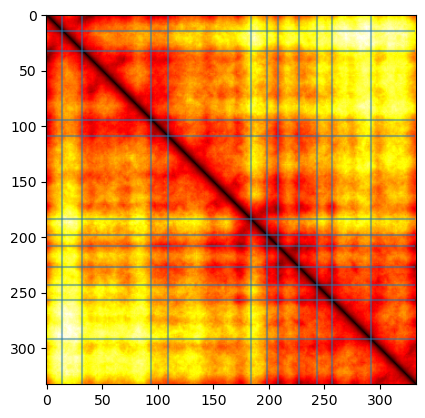

In [90]:
plt.imshow(np.median(dmaps, 2), cmap='hot')
plt.vlines(ctcf_df.bin.values, ymin=0, ymax=332, alpha=0.5)
plt.hlines(ctcf_df.bin.values, xmin=0, xmax=332, alpha=0.5)

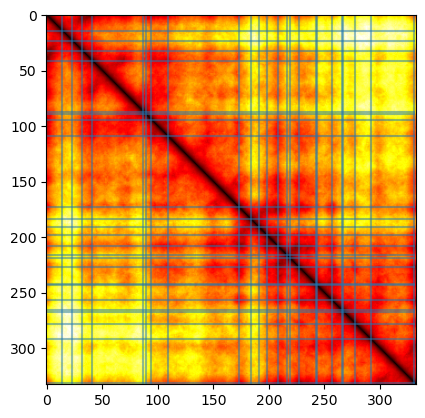

In [94]:
plt.imshow(np.median(dmaps, 2), cmap='hot')
plt.vlines(ring_df.bin.values, ymin=0, ymax=332, alpha=0.5)
plt.hlines(ring_df.bin.values, xmin=0, xmax=332, alpha=0.5)

In [91]:
ctcf_df.signalValue[ctcf_df.signalValue < 1000].median()

656.53188

In [92]:
ctcf_df

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,bin,dir,BEprob
94909,chr6,52027145,52027553,.,1000,.,791.73362,-1.0,5.23457,204,14,1,0.794459
111688,chr6,52045541,52045975,.,1000,.,1446.55594,-1.0,5.23457,222,32,2,0.999629
103573,chr6,52107417,52107818,.,1000,.,1080.84941,-1.0,5.23457,189,94,2,0.985841
85187,chr6,52122615,52123018,.,1000,.,534.96491,-1.0,5.23457,199,109,1,0.228699
77513,chr6,52197302,52197642,.,1000,.,392.13123,-1.0,5.23457,163,184,2,0.066359
110246,chr6,52211515,52211936,.,1000,.,1369.79677,-1.0,5.23457,212,198,2,0.999202
120043,chr6,52221594,52222073,.,1000,.,2273.76314,-1.0,5.23457,224,208,2,1.000000
119876,chr6,52240304,52240791,.,1000,.,2233.09605,-1.0,5.23457,245,227,2,1.000000
102154,chr6,52256910,52257336,.,1000,.,1026.60798,-1.0,5.23457,207,243,1,0.975891
99679,chr6,52270488,52270921,.,1000,.,938.62278,-1.0,5.23457,207,257,1,0.943795


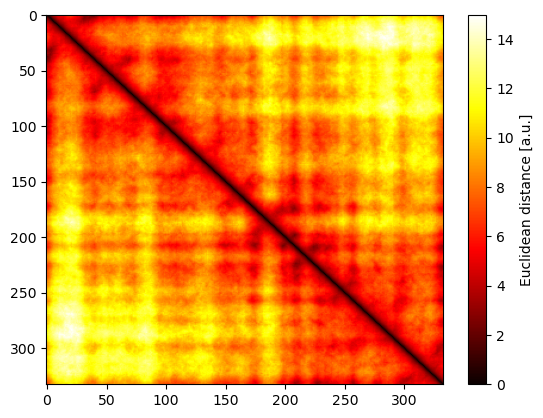

In [93]:
visualize_dmap(np.median(dmaps, 2))